In [2]:
import plotly.express as px
import plotly.graph_objects as go 

import pickle
with open(f'results/current_face_heatmaps.pkl', 'rb') as f:
    face_heatmaps = pickle.load(f)

fig = go.Figure()

buttons = [] 
visible_list = [False] * (len(face_heatmaps.keys()) + 1)


for idx, (label, heatmap_data) in enumerate(face_heatmaps.items()):
    fig.add_trace(go.Heatmap(z=face_heatmaps[label][::-1]))

current_visible_list = visible_list.copy()
current_visible_list[0] = True
current_visible_list[idx+1] = True
button = dict(
    method='update',
    label=label, 
    args=[{'visible': current_visible_list}]
)
buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=buttons[::-1],
            pad={"l":70, "t": -10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
        
    ], 
    width=500,
    height=600
)

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="Segment type:", showarrow=False,
                            x=5, y=1.10, yref="paper", align="left")
    ]
)

fig.show()

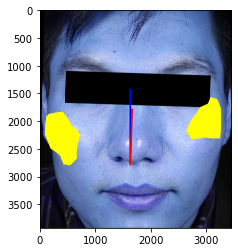

In [4]:
import cv2 
import matplotlib.pyplot as plt 

img = cv2.imread(f'gt/64_1.jpg') 
plt.imshow(img)
plt.show()

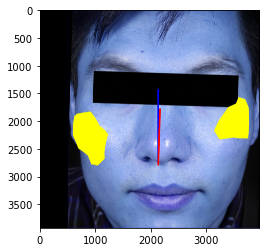

In [8]:
img_pad = cv2.copyMakeBorder(img, 0, 0, 500, 0, cv2.BORDER_CONSTANT, (0,0,0))
plt.imshow(img_pad)